<a href="https://colab.research.google.com/github/Procuste34/lenia/blob/main/Custom_Lenia_avec_EvoJAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install evojax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.1/94.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 24.4 MB/s eta 0:00:00


In [ ]:
import evojax
import jax
import jax.numpy as jnp
import jax.scipy as jsp

import numpy as np
from collections import namedtuple
from functools import partial

#display
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns
import IPython.display

In [ ]:
#TODO : diff entre stack, dstack, vstack, concatenate...

In [ ]:
Carry = namedtuple('Carry', ['world', 'params', 'asset', 'temp'])
Params = namedtuple('Params', ['m', 's', 'h'])
Accum = namedtuple('Accum', ['world', 'stats'])
Asset = namedtuple('Asset', ['fK', 'X', 'reshape_c_k', 'reshape_k_c', 'R', 'T'])
Temp = namedtuple('Temp', ['last_center', 'last_shift', 'total_shift', 'last_angle'])
Stats = namedtuple('Stats', ['mass', 'center_x', 'center_y', 'speed', 'angle', 'ang_speed', 'is_empty', 'is_full'])
Others = namedtuple('Others', ['D', 'K', 'cells', 'init_cells'])

In [ ]:
def display_array(A, title, cmap='viridis'):
  plt.imshow(A, cmap=cmap, interpolation="nearest")
  plt.title(title)
  plt.show()

def display_video(A, title=None, step=1, cmap='viridis'):
  fig = plt.figure(figsize=(4,4), dpi=75, frameon=False)
  img = plt.imshow(A[0], cmap=cmap, interpolation="nearest", vmin=0)
  fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
  if title is not None:
    title = fig.text(0.05, 0.95, title, bbox={'facecolor':'w', 'alpha':0.5, 'pad':5}, ha="left")
  plt.close()
  def animate(i):
    # title.set_text(str(i))
    img.set_data(A[i*step])
  anim = matplotlib.animation.FuncAnimation(fig, animate, frames=A.shape[0]//step, interval=20)
  video = IPython.display.HTML(anim.to_html5_video())
  IPython.display.display(video)

def normalize(lst):
  a = np.asarray(lst)
  return (a - a.min()) / (a.max() - a.min())

def display_stats(stats:Stats):
  global n_discard
  fig = plt.figure(figsize=(20,4), dpi=75, frameon=False)
  ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=2)
  ax1.plot(stats.center_x, stats.center_y, '-c', marker=',', markerfacecolor='b')
  ax1.set_aspect('equal', adjustable='box')

  ax2 = plt.subplot2grid((2, 2), (0, 1))
  ax2.plot(stats.mass[5:], 'r', label="mass")
  ax2.plot(stats.speed[5:], 'b', label="speed")
  # ax2.plot(stats.angle[5:], 'y', label="angle")
  ax2.plot(stats.ang_speed[5:], 'g', label="angular speed")
  ax2.legend()

  ax3 = plt.subplot2grid((2, 2), (1, 1))
  ax3.plot(normalize(stats.mass[n_discard:]), 'r', label="mass")
  ax3.plot(normalize(stats.speed[n_discard:]), 'b', label="speed")
  # ax3.plot(normalize(stats.angle[n_discard:]), 'y', label="angle")
  ax3.plot(normalize(stats.ang_speed[n_discard:]), 'g', label="angular speed")
  plt.show()


In [ ]:
n_step = 200
n_discard = 50

world_size = 128
world_scale = 2

n_kernels = 15
n_channels = 3
cells_size = 20 #todo : update à partir du pattern loadé

n_cells = cells_size * cells_size * n_channels
n_params = 3 * n_kernels
n_genes = n_params + n_cells

# evolutionary algorithm related
n_population = 128  # population size
n_iteration = 30  # number of iternations
n_iter_interval = 1  # reporting interval

In [ ]:
bell = lambda x, mean, stdev: jnp.exp(-((x-mean)/stdev)**2 / 2)
growth = lambda x, mean, stdev: bell(x, mean, stdev) * 2 - 1

# Choix d'un pattern : 5N7KKM

In [ ]:
patterns = {}
patterns["5N7KKM"] = {"name":"Aquarium (swarm)","R":12,"T":2,"kernels":[
  {"b":[1],"m":0.22,"s":0.0628,"h":0.174,"r":0.87,"c0":0,"c1":0},
  {"b":[1],"m":0.351,"s":0.1539,"h":0.46,"r":0.52,"c0":0,"c1":0},
  {"b":[1,1/4],"m":0.177,"s":0.0333,"h":0.31,"r":0.58,"c0":0,"c1":0},
  {"b":[0,1],"m":0.126,"s":0.0525,"h":0.242,"r":0.89,"c0":1,"c1":1},
  {"b":[1],"m":0.437,"s":0.0797,"h":0.508,"r":0.78,"c0":1,"c1":1},
  {"b":[3/4,1],"m":0.234,"s":0.0369,"h":0.566,"r":0.79,"c0":1,"c1":1},
  {"b":[1],"m":0.179,"s":0.0653,"h":0.406,"r":1.0,"c0":2,"c1":2},
  {"b":[1],"m":0.489,"s":0.1213,"h":0.27,"r":0.64,"c0":2,"c1":2},
  {"b":[1],"m":0.419,"s":0.1775,"h":0.588,"r":0.96,"c0":2,"c1":2},
  {"b":[11/12,1],"m":0.341,"s":0.1388,"h":0.294,"r":0.66,"c0":0,"c1":1},
  {"b":[3/4,1],"m":0.469,"s":0.1054,"h":0.388,"r":0.69,"c0":0,"c1":2},
  {"b":[1,11/12],"m":0.369,"s":0.0721,"h":0.62,"r":0.61,"c0":1,"c1":0},
  {"b":[1],"m":0.219,"s":0.0898,"h":0.348,"r":0.81,"c0":1,"c1":2},
  {"b":[1/6,1],"m":0.385,"s":0.1102,"h":0.436,"r":0.81,"c0":2,"c1":0},
  {"b":[1],"m":0.208,"s":0.0749,"h":0.39,"r":0.71,"c0":2,"c1":1}],
  "cells":[
  [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0.12,0,0,0,0,0,0,0], [0,0,0,0,0.49,0,0,0,0,0,0,0.23,0.47,0.31,0.93,0.75,0,0,0,0], [0,0,0,0.23,0,0,0.65,0.68,0.12,0,0,0,0.02,0.40,0.82,0.86,0,0.19,0,0], [0,0,0.01,0.01,0.77,1.00,0.98,1.00,0.97,0.85,0.70,0.55,0.12,0.15,0.01,0,0,0.95,0,0], [0,0,0,0.66,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.74,0.76,0.27,0,0,0.18,0.59,0.31,0], [0,0.04,0.08,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.88,0.68,0.07,0,0,0,0,0,0], [0,0,0.29,1.00,1.00,1.00,1.00,0.90,1.00,0.92,0.58,0.84,0.89,0.39,0,0,0.04,1.00,0,0], [0,0.06,0.27,1.00,1.00,1.00,0.82,0.39,0,0,0,0.12,0.87,0.70,0.58,0.04,0.40,1.00,0.35,0], [0,0.21,0.38,1.00,1.00,0.66,0,0,0,0,0,0,1.00,0.79,0.74,0.16,0.31,0.42,0,0], [0,0.26,0.50,1.00,1.00,0.46,0,0,0,0,0,0.40,1.00,1.00,0.71,0.16,0,0.22,0,0], [0,0.14,0.48,1.00,1.00,0.77,0,0,0,0,0,1.00,1.00,1.00,0.79,0,0,0,0,0], [0,0,0.16,1.00,1.00,1.00,0.19,0,0,0.09,0.20,0.57,1.00,1.00,0.74,0,0,0,0,0], [0,0,0,0.59,1.00,1.00,0.85,0.75,1.00,1.00,1.00,1.00,1.00,1.00,0.47,0,0,0,0,0], [0,0,0,0,0.95,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.96,0.44,0,0,0,0,0], [0,0,0,0,0.25,0.79,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.96,0,0,0,0,0,0], [0,0,0,0,0.04,0.06,0.26,0.61,1.00,1.00,1.00,1.00,1.00,0,0,0.32,0,0,0,0], [0,0,0,0,0,0,0.15,0,0.02,0.23,0.24,0.05,0,0,0.25,0,0,0,0,0], [0,0,0,0,0,0,0,0,0.02,0.04,0,0,0.08,0,0,0,0,0,0,0]],
  [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0.03,0.43,0,0,0,0,0,0,0,0,0,0], [0,0,0.14,0.47,0,0,0.27,0.92,0.87,0.70,0,0,0,0,0,0,0,0,0,0], [0,0,0.86,1.00,0.66,1.00,1.00,1.00,1.00,0.33,0,0,0,0,0,0,0,0,0,0], [0,0,1.00,1.00,1.00,1.00,1.00,0.13,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,1.00,1.00,1.00,1.00,1.00,0,0.22,0.30,0,0,0,0,0,0,0,0,0,0], [0,0,0.76,1.00,1.00,1.00,1.00,1.00,0.83,0,0,0,0,0,0,0,0,0,0,0], [0,0,0.71,1.00,1.00,1.00,1.00,0.77,0.81,0.75,0,0,0,0,0,0,0,0,0,0], [0,0,0.69,1.00,1.00,1.00,0.88,0.24,0.35,0.62,0.35,0.09,0,0,0,0,0,0,0,0], [0,0,0.29,1.00,1.00,1.00,0.98,0.38,0.13,0.65,0.88,0.32,0,0,0,0,0,0,0,0], [0,0,0,0.09,1.00,1.00,1.00,0.93,0.77,0.88,0.24,0.03,0.69,1.00,0.78,0,0,0,0,0], [0,0,0,0,0.44,1.00,1.00,1.00,1.00,1.00,0.76,0.83,1.00,0.92,0.17,0,0,0,0,0], [0,0,0,0,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0,0,0,0,0,0,0], [0,0,0,0,0,0.36,1.00,1.00,1.00,1.00,1.00,1.00,0.12,0,0,0,0,0,0,0], [0,0,0,0,0,0.06,0.39,0.79,1.00,1.00,1.00,0.48,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0.16,0.59,1.00,1.00,1.00,0.13,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0.04,0.16,0.02,0,0,0,0,0,0,0,0]],
  [[0,0,0,0,0,0,0,0,0,0.51,0.46,0.26,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0.38,1.00,1.00,0.96,0.85,0.57,0,0,0,0,0,0,0], [0,0,0,0,0,0.06,0.63,1.00,1.00,1.00,1.00,0.96,0.70,0.08,0,0,0,0,0,0], [0,0,0,0,0.01,0.36,1.00,1.00,1.00,1.00,1.00,1.00,0.82,0.49,0,0,0,0,0,0], [0,0,0,0,0.05,0.50,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.99,0.65,0.04,0,0,0,0], [0,0,0.01,0,0.08,0.52,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.93,0,0,0,0,0], [0,0,0.03,0,0.09,0.49,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.58,0.04,0,0,0,0,0], [0,0,0.02,0,0.08,0.50,1.00,1.00,1.00,1.00,1.00,0.81,0,0,0,0,0.08,0.01,0,0], [0,0,0,0,0.04,0.47,1.00,1.00,1.00,1.00,0.40,0,0,0,0,0.77,0.85,0.35,0,0], [0,0,0,0,0.03,0.41,1.00,1.00,1.00,1.00,0.20,0,0,0.01,1.00,1.00,1.00,0.55,0,0], [0,0,0,0,0,0.30,0.98,1.00,1.00,1.00,0.68,0.09,0.26,1.00,1.00,1.00,1.00,0.70,0.19,0], [0,0,0,0,0,0.13,0.55,0.95,1.00,1.00,1.00,0.89,1.00,1.00,1.00,1.00,1.00,0.85,0.67,0.24], [0,0,0,0,0,0.02,0.31,0.63,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.88,0.45], [0,0,0,0,0,0,0.12,0.44,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.91,0.36], [0,0,0,0,0,0,0,0.16,0.48,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.86,0.06], [0,0,0,0,0,0,0,0,0.13,0.32,0.70,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.28,0], [0,0,0,0,0,0,0,0,0,0.06,0.18,0.32,0.57,0.90,1.00,1.00,1.00,0.08,0,0], [0,0,0,0,0,0,0,0,0,0,0,0.04,0.12,0.25,0.39,0.31,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0.02,0,0,0,0,0,0,0,0,0]]]
}

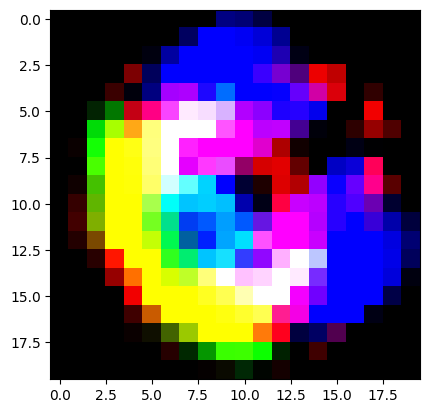

In [ ]:
plt.imshow(jnp.transpose(jnp.asarray(patterns['5N7KKM']['cells']), axes=[1, 2, 0]))

# fonctions auxiliaires

In [ ]:

def create_world_from_cells(cells):
  #cells : vecteur des cellules du pattern, de shape (e, e, c)

  cells_scaled = cells.repeat(world_scale, axis=-3).repeat(world_scale, axis=-2)
  cells_size_scaled = cells_size * world_scale

  midX = world_size//2
  midY = world_size//2

  A = jnp.zeros((world_size, world_size, n_channels)).at[midX-cells_size_scaled//2:midX+cells_size_scaled//2, midY-cells_size_scaled//2:midY+cells_size_scaled//2, :].set(cells_scaled)

  return A

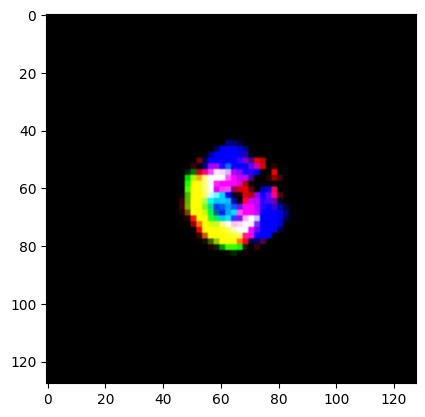

In [ ]:
plt.imshow(create_world_from_cells(jnp.transpose(jnp.asarray(patterns['5N7KKM']['cells']), axes=[1, 2, 0])))

In [ ]:
def load_pattern(pattern):
  kernels = pattern['kernels']
  R = pattern['R'] * world_scale
  dt = 1/pattern['T']
  cells = jnp.transpose(jnp.asarray(pattern['cells']), axes=[1, 2, 0])

  #update settings en conséquence du pattern loadé
  n_kernel = len(kernels)  # k
  n_channel = cells.shape[-1]  # c
  n_params = 3 * n_kernel  # 3*k
  cells_size = cells.shape[0]
  n_cells = cells_size * cells_size * n_channel  # e*e*c
  n_gene = n_params + n_cells

  #extraction des parametres
  m = jnp.array([k['m'] for k in kernels]) # (n_kernels,)
  s = jnp.array([k['s'] for k in kernels])
  h = jnp.array([k['h'] for k in kernels])
  init_params = jnp.vstack([m, s, h]) # (k=3, n_kernels)

  #c0, c1... TODO
  reshape_c_k = jnp.zeros(shape=(n_channels, n_kernels))  # (c,k)
  reshape_k_c = jnp.zeros(shape=(n_kernels, n_channels))  # (k,c)
  for i, k in enumerate(kernels):
    reshape_c_k = reshape_c_k.at[k['c0'], i].set(1.0)
    reshape_k_c = reshape_k_c.at[i, k['c1']].set(1.0)

  #calcul des kernels

  #midX = world_scale//2
  #Ds =[jnp.linalg.norm(jnp.mgrid[-midX:midX, -midX:midX], axis=0) * kernels[k]['b'] / (R * kernels[k]['r']) for k in range(n_kernels)]
  ''' TODO
  X = jnp.mgrid[-midX:midX, -midX:midX] / R
  D = jnp.linalg.norm(X, axis=0)  # (y,x), distance from origin
  Ds = [ D * len(k['b']) / k['r'] for k in kernels ]  # (y,x)*k
  Ks = [ (D<len(k['b'])) * jnp.asarray(k['b'])[jnp.minimum(D.astype(int),len(k['b'])-1)] * bell(D%1, 0.5, 0.15) for D,k in zip(Ds,kernels) ]  # (x,y)*k

  #Ks = [(D<len(k['b'])) * jnp.asarray(k['b'])[jnp.minimum(D.astype(int),len(k['b'])-1)] * bell(D%1, 0.5, 0.15) for D,k in zip(Ds, kernels)]
  K = jnp.dstack(Ks) # (y, x, k)
  nK = K / jnp.sum(K, axis=(0, 1), keepdims=True) # (y, x, k)
  fK = jnp.fft.fft2(jnp.fft.fftshift(nK, axes=(0,1)), axes=(0,1))
  '''

  mid = world_size // 2
  X = jnp.mgrid[-mid:mid, -mid:mid] / R  # (d,y,x), coordinates
  D = jnp.linalg.norm(X, axis=0)  # (y,x), distance from origin
  Ds = [ D * len(k['b']) / k['r'] for k in kernels ]  # (y,x)*k
  Ks = [ (D<len(k['b'])) * jnp.asarray(k['b'])[jnp.minimum(D.astype(int),len(k['b'])-1)] * bell(D%1, 0.5, 0.15) for D,k in zip(Ds,kernels) ]  # (x,y)*k
  K = jnp.dstack(Ks)  # (y,x,k), kernels
  nK = K / jnp.sum(K, axis=(0,1), keepdims=True)  # (y,x,k), normalized kernels
  fK = jnp.fft.fft2(jnp.fft.fftshift(nK, axes=(0,1)), axes=(0,1))  # (y,x,k), FFT of kernels

  #cy, cx = cells.shape[0], cells.shape[1]
  #py, px = cells_size - cy, cells_size - cx
  #init_cells = jnp.pad(cells, pad_width=((py//2, py-py//2), (px//2, px-px//2), (0,0)), mode='constant')  # (e,e,c)
  #A = create_world_from_cells(init_cells)

  A = create_world_from_cells(cells)

  init_carry = Carry(world=A, params=Params(m, s, h), asset=Asset(fK, X, reshape_c_k, reshape_k_c, R, dt), temp=Temp(jnp.zeros((2,)), jnp.zeros((2,), dtype=int), jnp.zeros((2,), dtype=int), 0.)) # int ??

  init_gene = jnp.concatenate([init_params.flatten(), cells.flatten()])

  other_asset = Others(D, K, cells, cells)

  return init_carry, init_gene, other_asset

In [ ]:
@jax.jit
def express_gene(carry, gene):
  global cells_size, n_kernels, n_channels, n_params, n_cells, n_gene, world_size, world_scale

  params = gene[:n_params].reshape((3, n_kernels))
  #cells_flatten = gene[n_params:]
  cells = gene[n_params:].reshape((cells_size, cells_size, n_channels))

  #params = params_flatten.reshape((3, n_kernels))


  #A = create_world_from_cells(cells_flatten)
  A = create_world_from_cells(cells)
  m, s, h = params

  carry = carry._replace(world=A)
  carry = carry._replace(params=Params(m, s, h))

  return carry

def step(carry, e, is_record=True):
  A = carry.world
  m, s, h = carry.params
  fK, X, reshape_c_k, reshape_k_c, R, dt = carry.asset
  last_center, last_shift, total_shift, last_angle = carry.temp

  m = m[None, None, ...]  # (1,1,k)
  s = s[None, None, ...]  # (1,1,k)
  h = h[None, None, ...]  # (1,1,k)

  #recentrage
  A = jnp.roll(A, -last_shift, axis=(-3, -2)) # (y, x, c) TODO

  #step
  fA = jnp.fft.fft2(A, axes=(-3, -2))  # (y, x, c)
  fA_k = jnp.dot(fA, reshape_c_k)  # (y,x,k)
  U_k = jnp.real(jnp.fft.ifft2(fK * fA_k, axes=(-3, -2)))  # (y, x, k)
  G_k = growth(U_k, m, s) * h  # (y,x,k)
  G = jnp.dot(G_k, reshape_k_c)  # (y,x,c)
  next_A = jnp.clip(A + dt * G, 0, 1)  # (y,x,c)

  #centre
  m00 = A.sum()
  AX = next_A.sum(axis=-1)[None, ...] * X  # (d,y,x)
  center = AX.sum(axis=(-2, -1)) / m00  # (d)
  shift = (center * R).astype(int)
  total_shift += shift

  #décentrer pour visualisation
  if is_record:
    actual_A = jnp.roll(next_A, total_shift - shift, axis=(0, 1))
  else:
    actual_A = 0

  # calculate mass & speed
  mass = m00 / R / R
  actual_center = center + total_shift / R
  center_diff = center - last_center + last_shift / R
  speed = jnp.linalg.norm(center_diff) / dt

  # calculate angular speed
  angle = jnp.arctan2(center_diff[1], center_diff[0]) / jnp.pi  # angle = [-1.0, 1.0]
  angle_diff = (angle - last_angle + 3) % 2 - 1
  angle_diff = jax.lax.cond(speed > 0.01, lambda: angle_diff, lambda: 0.0)
  ang_speed = angle_diff / dt

  # check if world is empty or full
  is_empty = (next_A < 0.1).all(axis=(-3, -2)).any()
  borders = next_A[...,0,:,:].sum() + next_A[...,-1,:,:].sum() + next_A[...,:,0,:].sum() + next_A[...,:,-1,:].sum()
  is_full = borders > 0.1

  #pack
  carry = carry._replace(world = next_A)
  carry = carry._replace(temp = Temp(center, shift, total_shift, angle))
  stats = Stats(mass, actual_center[1], -actual_center[0], speed, angle, ang_speed, is_empty, is_full)
  accum = Accum(actual_A, stats)

  return carry, accum

step_light = partial(step, is_record=False)

In [ ]:
def calc_fitness(stats, metric, operator, discard=50):
  if   metric == 'speed':      metric = stats.speed
  elif metric == 'ang_speed':  metric = jnp.abs(stats.ang_speed)
  elif metric == 'mass':       metric = stats.mass
  elif metric == 'angle':      metric = stats.angle
  stable_metric = metric[discard:]  # discard stats when the pattern is still stable
  if   operator == 'avg':  fitness = jnp.mean(stable_metric)
  elif operator == 'var':  fitness = jnp.var (stable_metric)

  # fitness is 0 if vanish or explode
  failed = jnp.logical_or(stats.is_empty.any(), stats.is_full.any())
  fitness = jax.lax.cond(failed, lambda: 0.0, lambda: fitness)

  return fitness


In [ ]:
fitness_metric = 'speed'
fitness_oper = 'avg'


def simulate( init_gene):
  global init_carry

  init_carry = express_gene(init_carry, init_gene)
  carry, series = jax.lax.scan(step, init=init_carry, xs=np.arange(n_step))
  fitness = calc_fitness(series.stats, fitness_metric, fitness_oper)

  return fitness, series

def evaluate(init_gene):
  global init_carry

  init_carry = express_gene(init_carry, init_gene)
  carry, series = jax.lax.scan(step_light, init=init_carry, xs=np.arange(n_step))
  fitness = calc_fitness(series.stats, fitness_metric, fitness_oper)

  return fitness

evaluate_batch = jax.vmap(evaluate, in_axes=( 0), out_axes=0)
#evaluate_batch = jax.experimental.maps.xmap(evaluate, in_axes=(['b', ...], ), out_axes=['b', ...])

Initial fitness =  0.06990965


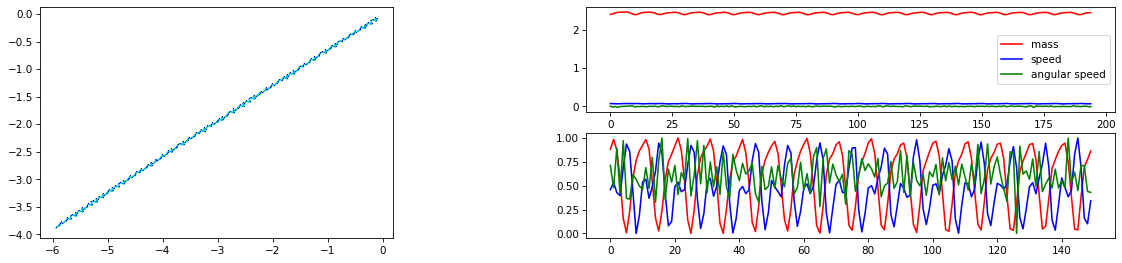

In [ ]:
pattern = patterns["5N7KKM"]
init_carry, init_gene, other_asset = load_pattern(pattern)

fitness, series = simulate(init_gene)
print("Initial fitness = ", fitness)
display_video(series.world, step=1, title=f"fitness={fitness:0.6f}")
display_stats(series.stats)

In [ ]:
solver = evojax.algo.CMA_ES_JAX(
    pop_size=n_population,
    param_size=n_genes,
    mean=init_gene,
    init_stdev=0.01,
)

fitness_list = []
series_list = []
for iter in range(n_iteration):
  gene_batch = solver.ask()  # (pop, gene)
  fitness_batch = evaluate_batch(gene_batch)  # (pop)
  solver.tell(fitness_batch)

  if iter % n_iter_interval == 0 or iter == n_iteration:
    best_gene = solver.best_params  # (gene)
    best_fitness = evaluate(best_gene)
    print(f"iteration #{iter:02d}: best fitness = {best_fitness:0.6f}")
    fitness_list.append(best_fitness)
    fitness, series = simulate(best_gene)
    # series_list.append(series.world)  # run this if want to show all results

iteration #00: best fitness = 0.100876


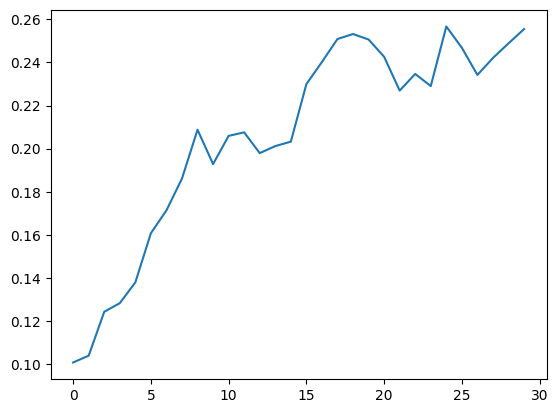

Best fitness =  0.25543067


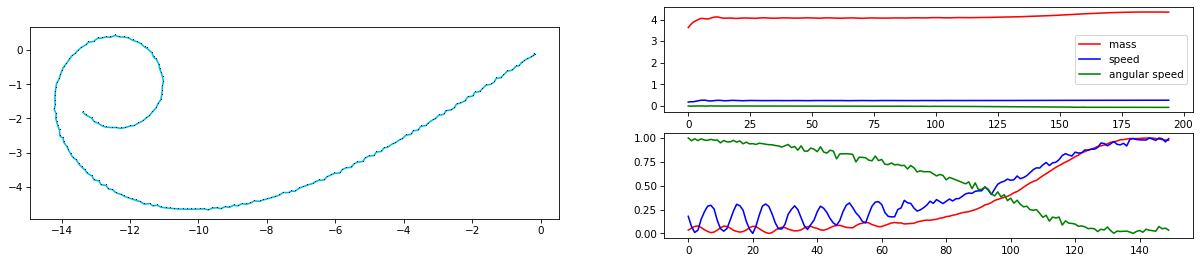

In [ ]:
plt.plot(fitness_list)
plt.show()

fitness, series = simulate(best_gene)
print("Best fitness = ", fitness)
display_video(series.world, step=1, title=f"fitness={fitness:0.6f}")
display_stats(series.stats)